# Offline Hand-Eye Calibration

> Copyright (c) 2025, Thao Dang, Esslingen University. <br>
> This file is part of the offline_hand_eye package (see https://github.com/robgineer/cobot). <br>
> License: 3-clause BSD, see https://opensource.org/licenses/BSD-3-Clause

To run this jupyter notebook, you may need to create an appropriate juptyer kernel. 

Please refer to the [Readme](../README.md) for doing so with either miniconda or venv. 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import json
import sys
import glob

from dt_apriltags import Detector

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../offline_hand_eye")))
from calib_io_utils import save_calibration, load_calibration
from calibration_utils import load_and_detect, show_detections, compute_hand_eye_calibration, frame_is_valid, compute_TCP_image_position, compute_target_to_gripper_transform, compute_target_image_position, compute_reprojection_error_mean_max

In [2]:
data_root = '../doc/sample_data/calibration/calibdata_2025_08_11-11_51_22'
calibration_config_file = '../../../handeye_calibration_params.json'

with open(calibration_config_file, 'r') as f:
    calibration_config = json.load(f)

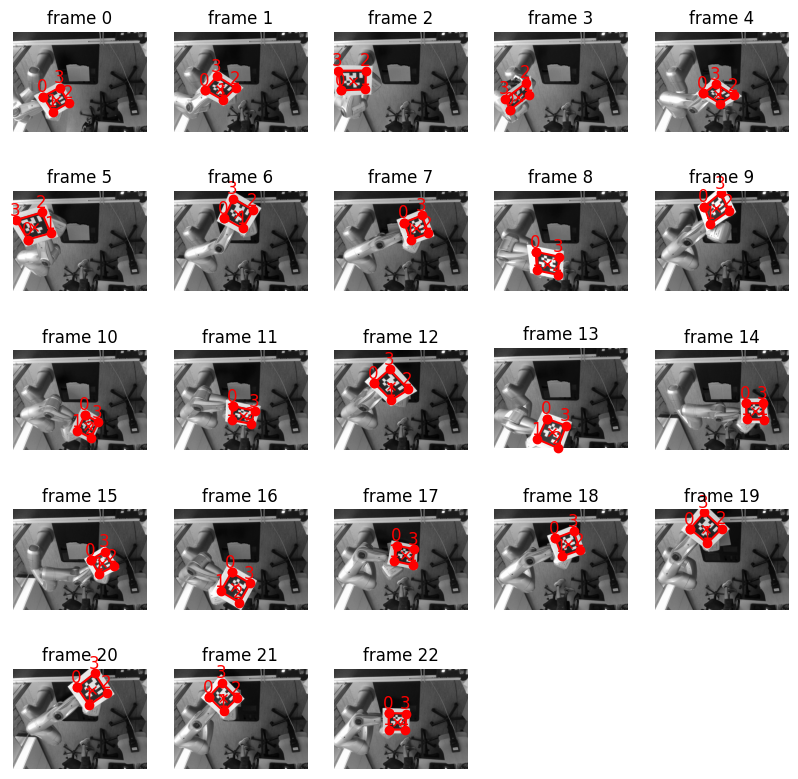

In [3]:
apriltag_family = 'tag36h11' # AprilTag family used in the calibration
tagsize = 0.14  # size of the AprilTag side in meters
detector = Detector(families=apriltag_family,
                    nthreads=1,
                    quad_decimate=1.0,
                    quad_sigma=0.0,
                    refine_edges=1,
                    decode_sharpening=0.25,
                    debug=0)

num_frames = len(glob.glob1(data_root, "frame_*.pkl"))
plt.figure(figsize=(10, 10))
for i, frame_count in enumerate(np.linspace(0, num_frames-1, min(num_frames, 25), dtype=int)): 
    frame, gray, detections = load_and_detect(frame_count, data_root, detector, tagsize)

    plt.subplot(5, 5, i + 1)
    show_detections(gray, detections, apriltag_family, show_legend=False, show_family=False)
    plt.title('frame %d' % frame_count)

In [4]:
frame, gray, detections = load_and_detect(frame_count=10, data_root=data_root, detector=detector, tagsize=tagsize)
frame

{'image_timestamp': (1754913281, 881792236),
 'robot_transform': OrderedDict([('translation',
               OrderedDict([('x', 0.5927182330326759),
                            ('y', 0.9605102301348581),
                            ('z', 0.017515726128091158)])),
              ('rotation',
               OrderedDict([('x', 0.848245601608102),
                            ('y', 0.21850021141091713),
                            ('z', -0.4217332821607434),
                            ('w', 0.23426074294217644)]))]),
 'tracking_transform': None,
 'camera_info': OrderedDict([('header',
               OrderedDict([('stamp',
                             OrderedDict([('sec', 1754913281),
                                          ('nanosec', 481502441)])),
                            ('frame_id', 'camera_color_optical_frame')])),
              ('height', 480),
              ('width', 640),
              ('distortion_model', 'plumb_bob'),
              ('d', [0.0, 0.0, 0.0, 0.0, 0.0]),
          

In [5]:
frame_samples = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

for frame_count in frame_samples:
    frame, gray, detections = load_and_detect(frame_count=frame_count, data_root=data_root, detector=detector, tagsize=tagsize)
    if not frame_is_valid(frame, detections):
        print(f"Error: Invalid frame {frame_count}")

In [6]:
hand_camera_rot, hand_camera_tr, hand_camera_qwxyz = compute_hand_eye_calibration(data_root, frame_samples, detector, tagsize)

print("Hand-Eye Calibration Results:")
print("Rotation Matrix:")
print(hand_camera_rot)
print("Quaternion (wxyz):")
print(hand_camera_qwxyz)
print("Translation Vector:")
print(hand_camera_tr)

Hand-Eye Calibration Results:
Rotation Matrix:
[[-0.99138144  0.01173727  0.13048015]
 [ 0.10257142  0.68912947  0.71734209]
 [-0.08149808  0.72454317 -0.68439408]]
Quaternion (wxyz):
[0.05777964 0.03115752 0.91718387 0.39301969]
Translation Vector:
[[-0.62479568]
 [-0.46656602]
 [ 1.52217696]]


In [7]:
calibration_file = '../../../handeye_calibration.json'
if True:
    save_calibration(calibration_file, calibration_config, hand_camera_qwxyz.tolist(), hand_camera_tr.tolist(), 
                     frame_samples, data_root)

    loaded_calibration = load_calibration(calibration_file)
    print("Loaded Calibration:")
    print(loaded_calibration)   

Loaded Calibration:
{'calibration_type': 'eye_on_base', 'robot_base_frame': 'base_link', 'robot_effector_frame': 'gripper_tcp', 'tracking_base_frame': 'camera_color_optical_frame', 'translation': [[-0.6247956830719728], [-0.46656601880547577], [1.5221769602864774]], 'rotation_q_wxyz': [0.05777964191835807, 0.03115751658196012, 0.9171838677924369, 0.39301968754953936], 'selected_samples': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'data_file_path': '../doc/sample_data/calibration/calibdata_2025_08_11-11_51_22'}


## Stability testing

In [8]:
for method in ['TSAI', 'PARK', 'HORAUD', 'ANDREFF', 'DANIILIDIS']:
    rmat, tr, _ = compute_hand_eye_calibration(data_root, frame_samples, detector, tagsize, method_str=method)
    rvec, _ = cv2.Rodrigues(rmat)
    print('method=%10s' % method, ': rotation: ', rvec.flatten(), ', translation: ', tr.flatten())

method=      TSAI : rotation:  [0.07798182 2.78649121 1.13511794] , translation:  [-0.6252415  -0.46435337  1.53542584]
method=      PARK : rotation:  [0.09443945 2.78001433 1.19125554] , translation:  [-0.62479568 -0.46656602  1.52217696]
method=    HORAUD : rotation:  [0.09574446 2.77941862 1.19156981] , translation:  [-0.62501846 -0.46661875  1.52194257]
method=   ANDREFF : rotation:  [0.09664046 2.78028913 1.19177476] , translation:  [-0.58973461 -0.38587882  1.45872222]
method=DANIILIDIS : rotation:  [0.08718721 2.7938845  1.15427423] , translation:  [-0.61280007 -0.4501613   1.53815468]


In [9]:
samples = frame_samples
for i in range(5):
    rmat, tr, _ = compute_hand_eye_calibration(data_root, samples, detector, tagsize)
    rvec, _ = cv2.Rodrigues(rmat)
    print('permutation=%02d' % i, ': rotation: ', rvec.flatten(), ', translation: ', tr.flatten())
    samples = np.random.permutation(frame_samples)

permutation=00 : rotation:  [0.09443945 2.78001433 1.19125554] , translation:  [-0.62479568 -0.46656602  1.52217696]
permutation=01 : rotation:  [0.09443945 2.78001433 1.19125554] , translation:  [-0.62482023 -0.46732256  1.518938  ]
permutation=02 : rotation:  [0.09443945 2.78001433 1.19125554] , translation:  [-0.62538487 -0.46695244  1.51954216]
permutation=03 : rotation:  [0.09443945 2.78001433 1.19125554] , translation:  [-0.62464642 -0.46723423  1.51815118]
permutation=04 : rotation:  [0.09443945 2.78001433 1.19125554] , translation:  [-0.625622   -0.46699811  1.51929161]


In [10]:
samples = np.random.permutation(frame_samples)
for i in range(5, len(samples)+1):
    rmat, tr, _ = compute_hand_eye_calibration(data_root, samples[:i], detector, tagsize)
    rvec, _ = cv2.Rodrigues(rmat)
    print('len=%02d' % i, ': rotation: ', rvec.flatten(), ', translation: ', tr.flatten())

len=05 : rotation:  [0.13123824 2.77258534 1.21799495] , translation:  [-0.62681125 -0.46590189  1.48180597]
len=06 : rotation:  [0.12776948 2.78228277 1.19905314] , translation:  [-0.62094817 -0.45276979  1.49964595]
len=07 : rotation:  [0.11514869 2.77907133 1.19774518] , translation:  [-0.62755694 -0.4614472   1.50716022]
len=08 : rotation:  [0.11282534 2.7761926  1.1983111 ] , translation:  [-0.62707289 -0.46202737  1.50203473]
len=09 : rotation:  [0.11048093 2.77658571 1.19355806] , translation:  [-0.62746468 -0.4601095   1.50311124]
len=10 : rotation:  [0.1093227  2.78636834 1.19911863] , translation:  [-0.61537832 -0.46016664  1.50339184]
len=11 : rotation:  [0.10562828 2.78360801 1.19878865] , translation:  [-0.62365966 -0.4681767   1.51683911]
len=12 : rotation:  [0.09685871 2.78444799 1.19938885] , translation:  [-0.62074896 -0.47039581  1.51493004]
len=13 : rotation:  [0.11009599 2.78574177 1.19586642] , translation:  [-0.62545483 -0.46612756  1.52127039]
len=14 : rotation: 

## Reprojection test

The green star shows the projection of the TCP in the image.

(array([[-0.58161552],
        [ 0.03814443],
        [ 0.77133358]]),
 array([367.95934569, 120.58662879]),
 array([[297.70811562,  90.22752269],
        [357.81941501, 174.6359692 ],
        [444.55740451, 116.65425774],
        [382.88972931,  23.85337837]]))

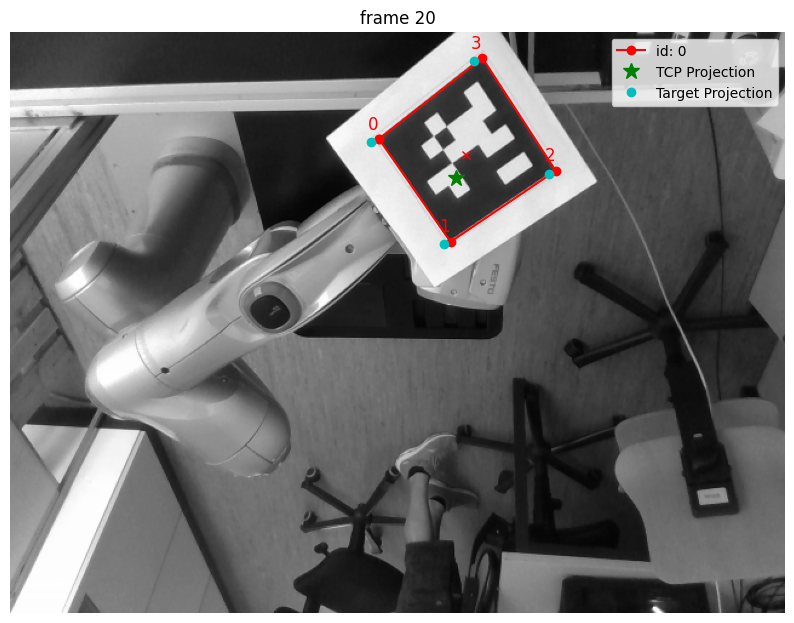

In [11]:
frame_count = 20

frame, gray, detections = load_and_detect(frame_count, data_root, detector, tagsize)
assert frame_is_valid(frame, detections), f"Frame {frame_count} is invalid"

plt.figure(figsize=(10, 10))
show_detections(gray, detections, apriltag_family, show_legend=False, show_family=False)
plt.title('frame %d' % frame_count)

img_points, TCP_world = compute_TCP_image_position(frame, hand_camera_rot, hand_camera_tr)
plt.plot(img_points[0], img_points[1], 'g*', ms=12, label='TCP Projection')

rvec_target_to_gripper, tvec_target_to_gripper = compute_target_to_gripper_transform(hand_camera_rot, hand_camera_tr, data_root, frame_samples, detector, tagsize)
xc_proj = compute_target_image_position(frame, hand_camera_rot, hand_camera_tr, rvec_target_to_gripper, tvec_target_to_gripper, tagsize)
plt.plot(xc_proj[:,0], xc_proj[:,1], 'c.', ms=12, label='Target Projection')
plt.legend()

TCP_world, img_points, xc_proj

In [12]:
calibration_variants = ['TSAI', 'PARK', 'HORAUD', 'ANDREFF', 'DANIILIDIS']

for method in calibration_variants:
    print(f"Running calibration method: {method}")
    rmat, tr, _ = compute_hand_eye_calibration(data_root, frame_samples, detector, tagsize, method_str=method)
    rvec_target_to_gripper, tvec_target_to_gripper = compute_target_to_gripper_transform(rmat, tr, data_root, frame_samples, detector, tagsize)

    print(f". Translation to gripper: %s" % tvec_target_to_gripper.flatten())
    print(f". Rotation to gripper   : %s" % rvec_target_to_gripper.flatten())

    mean_error, max_error = compute_reprojection_error_mean_max(rmat, tr, data_root, frame_samples, detector, rvec_target_to_gripper, tvec_target_to_gripper, tagsize)
    print(f'. Distance between projected and detected target center: mean={mean_error:.2f}px, max={max_error:.2f}px')


Running calibration method: TSAI
. Translation to gripper: [-0.07503365  0.00971542  0.05072427]
. Rotation to gripper   : [-0.61314301  1.46031138 -0.65912474]
. Distance between projected and detected target center: mean=9.83px, max=21.95px
Running calibration method: PARK
. Translation to gripper: [-0.07119538 -0.00389558  0.03823691]
. Rotation to gripper   : [-0.59829752  1.49470611 -0.66168455]
. Distance between projected and detected target center: mean=5.28px, max=13.52px
Running calibration method: HORAUD
. Translation to gripper: [-0.07110718 -0.00369115  0.03806448]
. Rotation to gripper   : [-0.59801382  1.49527128 -0.66087569]
. Distance between projected and detected target center: mean=5.28px, max=13.64px
Running calibration method: ANDREFF
. Translation to gripper: [ 0.01446659  0.01765932 -0.00658112]
. Rotation to gripper   : [-0.59706387  1.49544992 -0.66095571]
. Distance between projected and detected target center: mean=26.05px, max=68.67px
Running calibration me